# Programming for Chemists: Physical Chemistry using NumPy, SciPy and SymPy

This is a hands on session where we will explore two worked examples in great detail to learn techniques in solving physical chemistry problems in Python. We will first discuss another useful Python library called [SymPy](https://www.sympy.org/en/index.html). SymPy is a Python library for symbolic mathematics; aiming to become a full-featured **computer algebra system (CAS)**. 

**What is computer algebra?**

Computer algebra refers to software packages that are capable of doing **symbolic mathematical computations**; the word "algebraic" referring to operations with symbolic objects originating from algebra. Two examples of software you may have heard of are Maple and Mathematica. Scientific computing is usually based on **numerical** computation with **approximate floating point numbers**, while symbolic computation emphasises **exact** computation with expressions containing variables that have no given value and are manipulated as symbols. 


| Pros                                 | Cons                                                               |
|:-------------------------------------|:-------------------------------------------------------------------|
| Exact Arithmetic                     | **Much slower** than numerical computation                         |
| Non-linear expressions with symbols  | Poor hardware support                                              |
| Inequalities, differential equations | Difficult to parallelize                                           |
| Results can be formulae              | Numerical problems better handled with "orthodox" computer methods |
| It "knows" how to integrate          | Number ofxpressions can grow exponentially                         |

* Hydrogen atom optimisation Gaussian vs slater
* Numerical integration
* differential equations
* Analytical integration using SymPy

## Solving the Hydrogen Atom 

The hydrogen atom is the building block of a lot of computational and quantum chemical methods. It can be described using the time independent, non-relativistic Schr&ouml;dinger equation

\\[
 \hat{H}\psi = E\psi,
 \tag{1}
\\]

where: 
* \\(\hat{H} \\) is the Hamiltonian. 
* \\(\psi\\) is the wavefunction. 
* \\(E\\) is the energy. 

This is the textbook system studied in quantum mechanics as it is one of the most simple, consisting of a single proton and electron. The radial part of the hydrogen atom is **exactly solvable** using a series solution method but lets pretend we are unaware of this and explore how a computer can solve it. The aim will be to get the computer to do *everything*, requiring no preliminary mathematics by us humans. We are going to use a very powerful mathematical technique called the **variational method**; using a combination of symbolic mathematics from SymPy and numerical techniques from SciPy. 

### Variational Method 

Consider the wave equation given in equation (1). If we multiply both sides by \\(\psi\\) and integrate over all space we end up with the following

\\[
E = \frac{\int \psi \hat{H}\psi \text{d}\tau}{\int \psi^2 \text{d}\tau}.
\tag{2}
\\]

When \\(\psi\\) is complex this becomes

\\[
E = \frac{\int \psi^* \hat{H} \psi \text{d}\tau}{\int \psi^* \psi \text{d}\tau}.
\tag{3}
\\]

We can now calculate the energy, \\(E\\) if we know the wavefunction, \\(\psi\\). If we do not know the exact wavefunction our best bet is to have an educated guess of the wavefunction form using some physical intuition; unlikely to be the exact wavefunction, but by labelling it as \\(\psi_1\\) it will give us a value of the energy, \\(E_1\\). 

We can now guess a second wavefunction, \\(\psi_2\\), resulting in an energy value \\(E_2\\) and if desired we could guess even more wavefunctions, there is no limit. The variational principle tells us that if \\(E_g\\) is the exact ground state energy then both \\(E_1\\) and \\(E_2\\) will always be greater than \\(E_g\\) unless we somehow guess the exact wavefunction; which would then be equal to \\(E_g\\). We can represent the variational principle via the following inequality

\\[
\frac{\int\psi^* \hat{H} \psi \text{d}\tau}{\int \psi^* \psi \text{d}\tau} \ge E_g.
\tag{4}
\\]


Due to the inability of solving many-body problems exactly, computational and quantum chemistry is built upon approximate methods and a number of methods utilize the variational principle, such as **Hartree Fock theory**. These work by making repeated iterative changes to the trial wavefunctions or density matrices, calculating the energy as they go until the lowest value has been found; safe in the knowledge it can not drop below the exact ground state solution.

For our first trial wavefunction, \\(\psi_1\\), we will use a single Gaussian function

\\[
\psi_1 = e^{-cr^2},
\\]

where \\(r\\) is the nucleus-electron distance and \\(c\\) is a **variational parameter** which we will get our program to change throughout the calculation in order to find the lowest energy, \\(E_g\\). The Hamiltonian for the hydrogen atom is

\\[
\hat{H} = -\overbrace{\frac{\hbar^2}{2\mu}\nabla^2}^{K.E} - \overbrace{\frac{e^2}{r}}^{P.E},
\tag{5}
\\]

where \\(\mu\\) represents the reduced mass of the proton-electron pair (\\(\mu \approx 1\\) for the hydrogen atom).

Import NumPy, SciPy and SymPy. There is a useful module within the SciPy library called `Optimize` which contains a lot of functionality relevant for non-linear optimization problems. We want to import the `minimize` function which we do using

`from scipy.optimize import minimize`

As we are going to solve this symbolically using computer algebra we also want to import the coordinate 'r' as a symbol from the `abc` module of SymPy using

`from sympy.abc import r`

In [18]:
import numpy as np
import scipy as sp
import sympy as sy

# import minimize function from optimize

# import r from abc


Minimization problems can sound difficult so lets simplify the process:
    
1. Give a starting value for the variational parameter (the computer needs a starting point).
2. Calculate the quantity you are minimising.
3. Change value of variational parameter.
4. Calculate quantity again and compare to the first calculation; is the value lower or higher?
5. Keep changing the value of the variational parameter until the quantity being calculated can not go lower -> you have reached the minimum.

This 5-step guide outlines the principles of a minimization calculation. The mathematical algorithms involved in how to select the next best guess for your variational parameter are complex making up an entire field of mathematics known as non-linear optimization.

We need to keep changing the value of the variational parameter, \\(c\\), so need a Python object which can continually take unique input and return unique output -> **Function**. Let us define a function called `min_energy(c):` and write a placeholder docstring:

In [18]:
def min_energy(c):
    '''
    This function minimises the energy, E, with respect to a single variational parameter c
    
    Parameters:
    -----------
    c : 
        
    
    Returns:
    --------
    E : 
        

    '''

**Define wavefunction:**

The first step is to tell the program what our Gaussian wavefunction looks like:

`psi_1 = sy.exp(-c*r**2)`

where we have called the SymPy implementation of the exponential function. 

**Define Hamiltonian:**

We will next define the Hamiltonian operator and get SymPy to evaluate the differential operators for us, symbolically! Remember an operator, our Hamiltonian, only makes sense if it **is acting on something** so we will act it on the wavefunction on its right hand side of equation (4):

`hamiltonian = (-1/2)*(sy.diff(psi_1, r, r) + (2/r)*sy.diff(psi_1, r)) - (1/r)*psi_1`

There is a lot to unpack here so lets break it down:

1. `sy.diff` calls the differential operator from SymPy. The first differential in our \\(\nabla^2\\) operator is a second order derivative with respect to \\(r\\) which can be programmed in two equivalent ways:

    `sy.diff(psi_1, r, r)` or `sy.diff(psi_1, r, 2)`

2. the next derivative is first order:

    `sy.diff(psi_1, r)`

3. we also need to multiply the potential energy term at the end by `psi_1` as it is also part of the Hamiltonian operator.

**Volume element:**

Next we need to consider **Heisenberg's uncertainty principle**, relating to how the electron will not idly sit at a fixed position from the proton; but instead have a finite probability of existing at any position in the sphere traced out by "swinging" the radius joining the proton and electron around. The surface area of a sphere is \\(4\pi r^2\\) which we will program as our volume element, `dv`, remember to use `sy.pi`.

**Integration:**

We have now defined our wavefunction, Hamiltonian operator and volume element, so we can now conduct the integration. We will implement two expressions, one for the numerator of equation (4) and one for the denominator:

`num = sy.N(sy.integrate(psi_1*hamiltonian*dv, (r, 0, sy.oo)))`

Lets break this down:

1. To symbolically integrate in SymPy we call:

    `sy.integrate(integrand, (variable to integrate over, start, end))` 

2. We want to integrate over \\(r\\) from 0 to \\(\infty\\) as quantum mechanics tells us the electron can technically reside in a sphere stretching out to the edge of the Universe, even though the probability is effectively zero past a radius of a few Bohr radii.

    `(r, 0, sy.oo)`

    infinity is represented as `oo` in Sympy. The denominator can be programmed using an almost identical syntax, *have a go yourself*. 

3. As SymPy evaluates it symbolically, it will leave it in a general form (print out the result to check for yourself!) and we want a numeric answer so call `sy.N` which numerically evaluates the expressions for us.

We then calculate the energy by dividing: `E = num/den`. A useful feature of an optimisation program is to output each step of the optimisation process so the user can see what is happening. We can print out the value of `c` and `E` each time the function is called:

`print("c = {:.6f}, Energy = {:.10f}".format(c, E))`

We are finished! You can fill in the following function using what we just discussed. Outside the function we set the initial value of `c=3` and then call the minimize function from SciPy which varies the value of `c` until it has achieved a convergence tolerance of \\(1 \times 10^{-6}\\), `tol=1e-6`, or 6 decimal places:

In [ ]:
def min_energy(c):
    '''
    This function minimises the energy with respect to a single variational parameter c
    
    Parameters:
    -----------
    c : 
        
    
    Returns:
    --------
    E : 
        

    '''
    # The scipy minimize function passes the parameters in an array. 
    # To use it within our mathematical formulae we need to extract it as a separate number, done using the index [0]
    c = c[0]
    
    # define the Gaussian wavefunction

    # define the Hamiltonian

    # define the volume of integration

    # define the numerator of the variational principle

    # define the denominator of the variational principle

    # calculate the energy
    E = num/den

    # print the current value of c and E 
    
    # return E to the minimize function
    return E

# set an initial value for the variational parameter 'c'
c = 3

# call the minimize function, tell it the parameter to vary, c, and tell it the tolerance for convergence, tol
hydrogen_gs = minimize(min_energy, c, tol=1e-6)

# print the final result to terminal
print(hydrogen_gs)

We have a final energy of \\(E_g = -0.4244131816\\) hartrees when \\(c = 0.28294212\\). This is not too bad, but we know the exact ground state energy for a one-electron system

\\[
E_g = -\frac{Z^2}{2},
\\]

where \\(Z\\) is the nuclear charge, so for the hydrogen atom \\(E = -0.5\\) hartrees. This means using a Gaussian wavefunction results in an energy incorrect by \\(\approx 15\%\\) so not brilliant...

**Better wavefunction approximation:**

Let us consider a better approximation for our wavefunction, this time using a **Slater-type orbital**:

\\[
\psi_2 = e^{-cr}.
\\]

Why is this better? Lets plot the Slater function against the Gaussian using matplotlib:

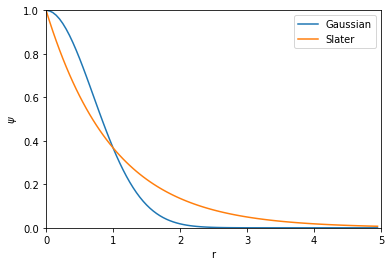

In [45]:
from matplotlib import pyplot as plt
import numpy as np

# create the figure (fig) and axes (ax) objects
fig, ax = plt.subplots()

# create r range from 0 -> 5 with a step of 0.05
r = np.arange(0, 5, 0.05)   # start, stop, step

# define gaussian function
gaussian = np.exp(-r**2)

# define slater function
slater = np.exp(-r)

# set the range of the x-axis data
ax.set_xlim([0, 5])

# set the range of the y-axis data
ax.set_ylim([0, 1])

# set the axis labels
ax.set_xlabel('r')
ax.set_ylabel(r'$\psi$')

# call the plot command
ax.plot(r, gaussian, label = 'Gaussian')
ax.plot(r, slater, label = 'Slater')

# plot the legend
ax.legend()

plt.show()

These two forms look quite different, and the key reason why the Slater form is more **physically realistic** than the Gaussian form is that it reaches a **cusp** at the origin, \\(r=0\\), which is a rule particles have to obey when they coalesce; rigorously proven by a mathematician called Tosio Kato in 1957. Change the scale(s) of the plot to get a closer look. 

Return to your program, or the complete version at the bottom of the script, and change the Gaussian function for a Slater-type function and see what you get.

We end up with \\(E_g = -0.5\\) hartrees when \\(c=1\\), matching the exact energy to the specified precision. This also reveals the nature of the exact wavefunction of the hydrogen atom but also any one-electron system

\\[
\psi = e^{-Zr},
\\]

where \\(Z\\) is the nuclear charge. We now have our optimised Gaussian and Slater type wavefunctions

**Gaussian:**

\\[
\psi_1 = e^{-0.28294212 r}
\\]

**Slater:**

\\[
\psi_2 = e^{-r}
\\]

We can use these wavefunctions to calculate the **radial probability density** of the hydrogen atom; i.e. the electron density around the nucleus

\\[
\int\limits_{0}^{\infty}\psi\psi|_r=x \text{d}r
\\]

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import sympy as sy

# create the figure (fig) and axes (ax) objects
fig, ax = plt.subplots()

# create r range from 0 -> 5 with a step of 0.05
r = np.arange(0, 5, 0.05)   # start, stop, step

# define gaussian function
gaussian = np.exp(-r**2)

# define slater function
slater = np.exp(-r)

dv = 4*np.pi*r**2

gaussian_norm = sy.N(sy.integrate(gaussian*gaussian*dv, (r, 0, sy.oo)))
slater_norm = sy.N(sy.integrate(slater*slater*dv, (r, 0, sy.oo)))

D_1 = gaussian*gaussian*dv / gaussian_norm
D_2 = slater*slater*dv / slater_norm

# set the range of the x-axis data
ax.set_xlim([0, 5])

# set the range of the x-axis data
ax.set_ylim([0, 3])

# set the range of the y-axis data
#ax.set_ylim([0, 1])

# set the axis labels
ax.set_xlabel('r')
ax.set_ylabel(r'$\psi$')

# call the plot command
ax.plot(r, D_1, label = 'Gaussian')
ax.plot(r, D_2, label = 'Slater')

# plot the legend
ax.legend()

plt.show()

## Complete Hydrogen Atom Program

In [5]:
import numpy as np
import scipy as sp
import sympy as sy
from scipy.optimize import minimize
from sympy.abc import r

def min_energy(c):
    '''
    This function minimises the energy with respect to a single variational parameter c
    
    Parameters:
    -----------
    c : np.ndarray
        This is the current value of the c parameter
    
    Returns:
    --------
    E : sympy.core.numbers.Float
        This number represents the energy value in hartrees

    '''
    # The scipy minimize function passes the parameters in an array. 
    # To use it within our mathematical formulae we need to extract it as a separate number, done using the index [0]
    c = c[0]

    # define the Gaussian wavefunction
    psi = sy.exp(-c*r**2)

    # define the Hamiltonian
    hamiltonian = (-1/2)*(sy.diff(psi, r, r) + (2/r)*sy.diff(psi, r)) - (1/r)*psi

    # define the volume of integration
    dv = 4*sy.pi*r**2

    # define the numerator of the variational principle
    num = sy.N(sy.integrate(psi*hamiltonian*dv, (r, 0, sy.oo)))

    # define the denominator of the variational principle
    den = sy.N(sy.integrate(psi*psi*dv, (r, 0, sy.oo)))

    # calculate the energy
    E = num/den

    # print the current value of c and E 
    #print("c = {:.6f}, Energy = {:.10f}".format(c, E))

    # return E to the minimize function
    return E

# set an initial value for the variational parameter 'c'
c = 3
bnds = ((0,10),)
# call the minimize function, tell it the parameter to vary, c, and tell it the tolerance for convergence
hydrogen_gs = minimize(min_energy, c, tol=1e-6, bounds=bnds)

print(hydrogen_gs)

      fun: -0.424413181561529
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.49795798e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 5
   status: 0
  success: True
        x: array([0.28294569])
